# Correlation between News and Price

In [1]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import datetime as dt

load_dotenv('../.env')
user = os.getenv("MONGODB_USER")
pwd = os.getenv("MONGODB_PWD")
host = os.getenv("MONGODB_HOST")
port = os.getenv("MONGODB_PORT")

client = MongoClient(f'mongodb://{user}:{pwd}@{host}:{port}')
display(client.list_database_names())

['admin', 'config', 'index_check', 'local', 'test_db']

In [2]:
db = client.test_db
db.list_collection_names()

['USDT-ETH', 'fred', 'USDT-BTC', 'news']

In [3]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2021, 6, 1)

## Load Data

In [4]:
import numpy as np
import pandas as pd
import pytz
from typing import Dict, List, Optional

In [5]:
btc_2021_half = pd.DataFrame(list(db['USDT-ETH'].
                              find({"utc_time":
                                   {"$gte":start, "$lt":end+dt.timedelta(1)}})))
btc_2021_half.tail(3)

,_id,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,unit,utc_time
12429,62e244dacc21c27346dec526,USDT-ETH,2021-06-01 20:00:00,2021-06-02 05:00:00,2550.0000,2550.00000,2550.00000,2550.00000,1622580918111,3696.450293,1.449588,60,2021-06-01 21:00:00
12430,62e244db89cb21df69d253b8,USDT-ETH,2021-06-01 21:00:00,2021-06-02 06:00:00,2540.2419,2611.25164,2530.91485,2533.94484,1622583963470,3227.004898,1.259560,60,2021-06-01 22:00:00
12431,62e244dc917611e64f0a9382,USDT-ETH,2021-06-01 21:00:00,2021-06-02 06:00:00,2540.2419,2611.25164,2530.91485,2533.94484,1622583963470,3227.004898,1.259560,60,2021-06-01 23:00:00


In [6]:
news_2021_half = pd.DataFrame(list(db['news'].
                              find({"etz_time":
                                   {"$gte":start, "$lt":end}})))
news_2021_half.tail(3)

,_id,BTC-News,ETH-News,etz_time
514,62e4ef2dcc5eed950fc2cc24,[Five Reasons Bitcoin’s Number Go Up Technolog...,"[As Bitcoin And Ethereum Collapse, Elon Musk B...",2021-05-29 23:59:00
515,62e4f043ec7b67ce398e36f9,"[Is crypto approaching its 'Netscape moment'?,...",[Instadapp: How two Indian brothers in their 2...,2021-05-30 23:59:00
516,62e4f16667c235fa695d2624,[How relevant is the $900M open interest on Bi...,[Cardano Leading Token in Crypto Market Recove...,2021-05-31 23:59:00


## Aggregate Data

In [7]:
def etz_timezone(timestamp, time_diff=-5):
    return timestamp + dt.timedelta(hours=time_diff)
    # return timestamp.tz_localize('UTC').tz_convert('US/Eastern')
btc_2021_half['etz_time'] = btc_2021_half['utc_time'].apply(lambda x: etz_timezone(x))

In [8]:
btc_2021_half = btc_2021_half[['etz_time','opening_price','high_price','low_price','trade_price','candle_acc_trade_volume','market']]
btc_2021_half.columns = ['etz_time','open','high','low','close','volume','market']
btc_2021_half['etz_time'] = btc_2021_half['etz_time'].apply(lambda x: x.date())

In [9]:
agg_option = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'market': 'first'}

btc_2021_half_day = btc_2021_half.groupby('etz_time').agg(agg_option)
etz_period = (btc_2021_half_day.index>=start.date())&(btc_2021_half_day.index<end.date())
btc_2021_half_day = btc_2021_half_day[etz_period].reset_index()
btc_2021_half_day.tail(3)

,etz_time,open,high,low,close,volume,market
514,2021-05-29,2530.543933,2557.832040,2183.303220,2311.85107,47.356469,USDT-ETH
515,2021-05-30,2306.574000,2478.813559,2276.170050,2277.53211,19.136943,USDT-ETH
516,2021-05-31,2323.454570,2708.936170,2305.787448,2665.83844,27.220295,USDT-ETH


In [10]:
news_2021_half.drop(['_id'], axis=1, inplace=True)
news_2021_half['etz_time'] = news_2021_half['etz_time'].apply(lambda x: x.date())

agg_2021_half = news_2021_half.merge(btc_2021_half_day, left_on='etz_time', right_on='etz_time')
agg_2021_half.tail(3)

,BTC-News,ETH-News,etz_time,open,high,low,close,volume,market
514,[Five Reasons Bitcoin’s Number Go Up Technolog...,"[As Bitcoin And Ethereum Collapse, Elon Musk B...",2021-05-29,2530.543933,2557.832040,2183.303220,2311.85107,47.356469,USDT-ETH
515,"[Is crypto approaching its 'Netscape moment'?,...",[Instadapp: How two Indian brothers in their 2...,2021-05-30,2306.574000,2478.813559,2276.170050,2277.53211,19.136943,USDT-ETH
516,[How relevant is the $900M open interest on Bi...,[Cardano Leading Token in Crypto Market Recove...,2021-05-31,2323.454570,2708.936170,2305.787448,2665.83844,27.220295,USDT-ETH


## BTC Price Candle Chart

In [11]:
import matplotlib.pyplot as plt
import mplfinance as fplt
import warnings
warnings.filterwarnings("ignore")

In [12]:
btc_2021_2m = btc_2021_half_day.copy()
btc_2021_2m['etz_time'] = btc_2021_2m['etz_time'].astype('datetime64[ns]')
btc_2021_2m = btc_2021_2m.set_index('etz_time').loc[dt.datetime(2021,4,1):end]

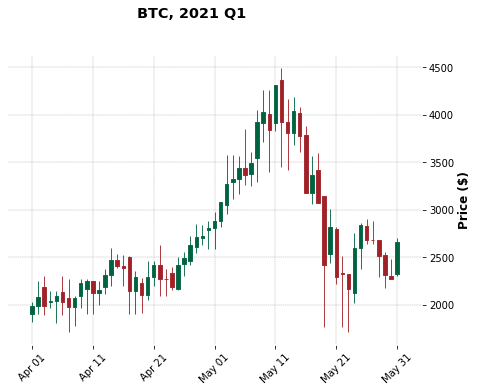

In [13]:
fplt.plot(
    btc_2021_2m,
    type='candle',
    style='charles',
    title='BTC, 2021 Q1',
    ylabel='Price ($)',)
plt.show()

## Positive vs Negative News

In [14]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from matplotlib.axes import Axes
from wordcloud import WordCloud
from collections import Counter
from itertools import chain

In [15]:
def count_words(sentences: List[str]) -> Counter:
    word_list = [word_tokenize(sentence) for sentence in sentences]
    word_list = sorted(chain.from_iterable(word_list))
    word_list = [re.sub('[^A-Za-z]', '', word).lower() for word in word_list]
    word_list = [word.capitalize() for word in word_list if word not in stop_words and len(word)]
    return Counter(word_list)

def plot_words(word_dict: Counter, ax: Axes, title: Optional[str]=None, fontsize=20) -> Axes:
    word_cloud = WordCloud(font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                            max_words=100, width=2000, height=1000,
                            prefer_horizontal= 1.0, background_color='white')
    word_cloud.generate_from_frequencies(word_dict)
    ax.imshow(word_cloud)
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=fontsize)
    return ax

In [16]:
agg_2021_half['state'] = np.where(agg_2021_half['close']-agg_2021_half['open'] < 0, 0, 1)

In [17]:
positive_news = list(chain.from_iterable(agg_2021_half[agg_2021_half['state']==1]['BTC-News']))
positive_news += list(chain.from_iterable(agg_2021_half[agg_2021_half['state']==1]['ETH-News']))

negative_news = list(chain.from_iterable(agg_2021_half[agg_2021_half['state']==0]['BTC-News']))
negative_news += list(chain.from_iterable(agg_2021_half[agg_2021_half['state']==0]['ETH-News']))

In [18]:
positive_words = {word.lower() for word,cnt in count_words(positive_news).most_common(50)}
negative_words = {word.lower() for word,cnt in count_words(negative_news).most_common(50)}
duplitcated_words = positive_words & negative_words
stop_words += duplitcated_words

In [19]:
positive_news = list(chain.from_iterable(agg_2021_half[agg_2021_half['state']==1]['BTC-News']))
positive_news += list(chain.from_iterable(agg_2021_half[agg_2021_half['state']==1]['ETH-News']))
positive_word_dict = count_words(positive_news)
print(positive_word_dict.most_common(5))

[('Bull', 128), ('Time', 125), ('One', 120), ('Big', 106), ('Launch', 106)]


In [20]:
negative_news = list(chain.from_iterable(agg_2021_half[agg_2021_half['state']==0]['BTC-News']))
negative_news += list(chain.from_iterable(agg_2021_half[agg_2021_half['state']==0]['ETH-News']))
negative_word_dict = count_words(negative_news)
print(negative_word_dict.most_common(5))

[('Hit', 89), ('Musk', 87), ('Support', 85), ('Future', 84), ('China', 82)]


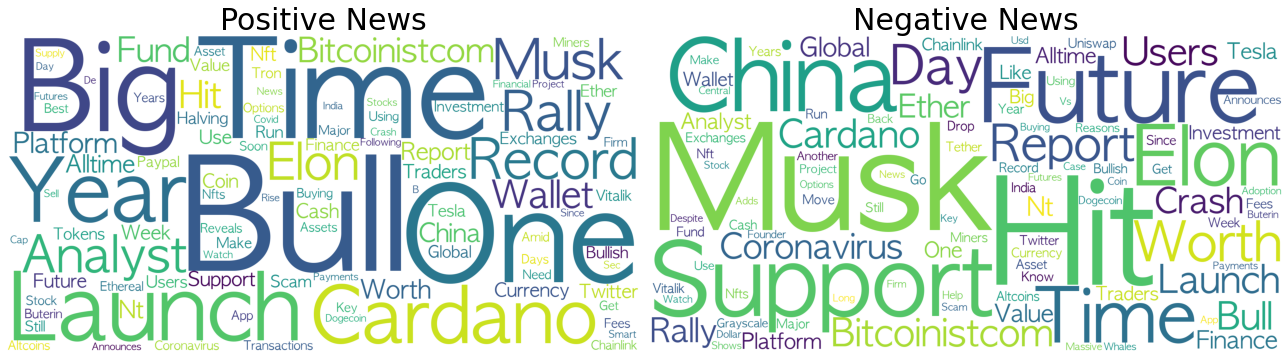

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
plot_words(positive_word_dict, ax[0], 'Positive News', fontsize=30)
plot_words(negative_word_dict, ax[1], 'Negative News', fontsize=30)
plt.tight_layout()
plt.show()

In [22]:
positive_df = pd.DataFrame(positive_word_dict.most_common(20),columns=['pword','pcount'])
negative_df = pd.DataFrame(negative_word_dict.most_common(20),columns=['nword','ncount'])
pd.concat([positive_df,negative_df],axis=1)

,pword,pcount,nword,ncount
0,Bull,128,Hit,89
1,Time,125,Musk,87
2,One,120,Support,85
3,Big,106,Future,84
4,Launch,106,China,82
5,Year,105,Elon,80
6,Cardano,105,Time,80
7,Record,105,Worth,80
8,Musk,104,Day,78
9,Rally,103,Report,77
